# Generative Adversarial Networks

## Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import time
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.utils import save_image

%matplotlib notebook
%config InlineBackend.figure_format = 'svg'

## Constants

In [2]:
DATA_DIR = "/home/SharedData/intern_sayan/GAN/MNIST"

CHECKPOINT_DIR = "/home/SharedData/intern_sayan/GAN/"
CHECKPOINT_G = "mnist_gan_gen.pth"
CHECKPOINT_D = "mnist_gan_dis.pth"

SHOULD_CHECKPOINT = True
LOAD_CHECKPOINT = False

!mkdir -p images

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
CUDA = 0
BATCH_SIZE = 64
EPOCHS = 120

img_shape = (1, 28, 28)
lr_g = 0.0002
lr_d = 0.00002
latent_dim = 100

## Data

# train batches: 938, # test batches: 157
train image: torch.Size([1, 28, 28])
test image: torch.Size([1, 28, 28])


Text(0.5,1,'Test')

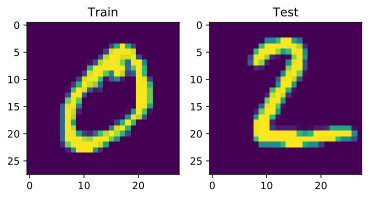

In [3]:
# Train Dataloader
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(DATA_DIR, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)

# Test Dataloader
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(DATA_DIR, train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)

print(f"# train batches: {len(train_loader)}, # test batches: {len(test_loader)}")

print(f"train image: {train_loader.dataset[0][0].size()}")
print(f"test image: {test_loader.dataset[0][0].size()}")

fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(train_loader.dataset[1][0].reshape(28,28))
a.set_title("Train")

a = fig.add_subplot(1,2,2)
plt.imshow(test_loader.dataset[1][0].reshape(28,28))
a.set_title("Test")

## Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        
        return img

## Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        p_value = self.model(img_flat)

        return p_value

## Training

In [6]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Generator & Discriminator
generator = Generator(latent_dim=latent_dim)
discriminator = Discriminator()

if CUDA is not None:
    adversarial_loss.cuda(CUDA)
    generator.cuda(CUDA)
    discriminator.cuda(CUDA)
    
if LOAD_CHECKPOINT:
    generator.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR,
                                                      CHECKPOINT_G)))
    discriminator.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR,
                                                          CHECKPOINT_D)))
    
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))

[Epoch 120/120] [D loss: 2.33150053] [G loss: 7125.90966797] in 7.04 secs 


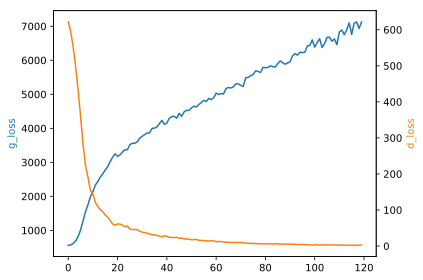

In [7]:
from IPython.display import clear_output

losses = {"generator" : list(), "discriminator": list()}

def display_progress(delta, epoch, epoch_d_loss, epoch_g_loss):
    clear_output(True)
    
    print(f"[Epoch {(epoch+1):3}/{EPOCHS}] [D loss: {epoch_d_loss:.8f}] [G loss: {epoch_g_loss:.8f}] in {delta:.2f} secs ")
    
    fig, ax1 = plt.subplots()
    ax1.plot(range(len(losses["generator"])), losses["generator"], "tab:blue")
    ax1.set_ylabel("g_loss", color="tab:blue")
    
    ax2 = ax1.twinx()
    ax2.plot(range(len(losses["discriminator"])), losses["discriminator"], "tab:orange")
    ax2.set_ylabel("d_loss", color="tab:orange")

    fig.tight_layout()
    
    plt.show()

for epoch in range(EPOCHS):
    epoch_g_loss, epoch_d_loss = 0,0
    delta = time.time()
    
    for batch_idx, (imgs, _label) in enumerate(train_loader):
        if CUDA is not None:
            # Adversarial ground truths
            valid = torch.autograd.Variable(torch.FloatTensor(imgs.size(0),
                                                              1).fill_(1.0).cuda(CUDA),
                                            requires_grad=False)
            fake = torch.autograd.Variable(torch.FloatTensor(imgs.size(0),
                                                             1).fill_(0.0).cuda(CUDA),
                                           requires_grad=False)

            # Real data
            real_imgs = torch.autograd.Variable(imgs.type(torch.Tensor)).cuda(CUDA)
            
            # Sampled noise
            z = torch.autograd.Variable(torch.FloatTensor(np.random.normal(0,
                                                                           1,
                                                                           (imgs.shape[0],
                                                                            latent_dim))).cuda(CUDA))
        else:
            # Adversarial ground truths
            valid = torch.autograd.Variable(torch.FloatTensor(imgs.size(0),
                                                              1).fill_(1.0),
                                            requires_grad=False)
            fake = torch.autograd.Variable(torch.FloatTensor(imgs.size(0),
                                                             1).fill_(0.0),
                                           requires_grad=False)

            # Real data
            real_imgs = torch.autograd.Variable(imgs.type(torch.Tensor))
            
            # Sampled noise
            z = torch.autograd.Variable(torch.FloatTensor(np.random.normal(0,
                                                                           1,
                                                                           (imgs.shape[0],
                                                                            latent_dim))))
        
        
        # Generator Training
        optimizer_G.zero_grad()
            
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()
        
        # Discriminator Training
        optimizer_D.zero_grad()
        
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        epoch_g_loss += g_loss.float()
        epoch_d_loss += d_loss.float()
        
        batches_done = epoch * len(train_loader) + batch_idx
        
        if batches_done % 1000 == 0:
            save_image(gen_imgs.data[:64], "images/epoch_{}_bd_{}.png".format(epoch, batches_done), nrow=8, normalize=True)
        
    delta = time.time() - delta
    
    losses["generator"].append(epoch_g_loss)
    losses["discriminator"].append(epoch_d_loss)
    
    if SHOULD_CHECKPOINT:
        torch.save(generator.state_dict(), os.path.join(CHECKPOINT_DIR,
                                                        CHECKPOINT_G))
        torch.save(discriminator.state_dict(), os.path.join(CHECKPOINT_DIR,
                                                            CHECKPOINT_D))
    
    display_progress(delta, epoch, epoch_d_loss, epoch_g_loss)
        

## Visualisation

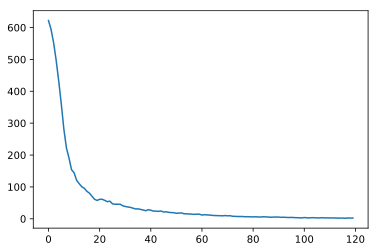

In [8]:
plt.plot(range(len(losses["discriminator"])), losses["discriminator"])

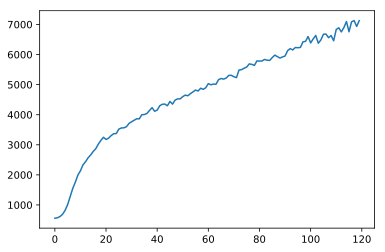

In [9]:
plt.plot(range(len(losses["generator"])), losses["generator"])

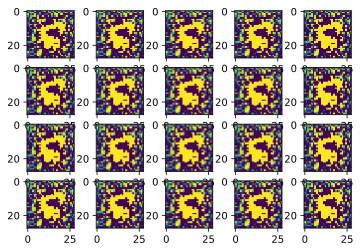

In [10]:
# Random sampling for inference
rows, cols = 4, 5
num_samples = rows * cols

if CUDA is not None:
    z = torch.autograd.Variable(torch.FloatTensor(np.random.normal(0,1, (num_samples, latent_dim))).cuda(CUDA))
else:
    z = torch.autograd.Variable(torch.FloatTensor(np.random.normal(0,1, (num_samples, latent_dim))))

image = generator(z).detach().cpu().numpy()

fig = plt.figure()

for row in range(rows):
    for col in range(cols):
        a = fig.add_subplot(rows, cols, row*cols + col + 1)
        plt.imshow(image[1].reshape(28, 28))